Melakukan import library untuk melakukan pengolahan dataset

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv2D ,Dense ,Flatten ,Dropout ,MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

Melakukan import dataset dari gdrive

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
training_file='/content/drive/MyDrive/Dataset/train.p'
testing_file='/content/drive/MyDrive/Dataset/test.p'

with open(training_file, mode='rb') as f:
  train=pickle.load(f)
with open(testing_file, mode='rb') as f:
  test=pickle.load(f)

print("Data Loaded")

Data Loaded


In [4]:
sign_name_df=pd.read_csv('/content/drive/MyDrive/Dataset/signname.csv')
SIGN_NAMES=sign_name_df.SignName.values
sign_name_df.set_index('ClassId',inplace=True)
sign_name_df.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


In [5]:
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format='retina'

Melakukan pemilihhan features dan label pada train

In [6]:
X ,y=train['features'], train['labels']

Menampilkan dimensi dari train

In [7]:
data=np.array(X)
labels=np.array(y)
print(data.shape,labels.shape)

(34799, 32, 32, 3) (34799,)


Melakukan pemilihan feature dan label pada test

In [8]:
X_test ,y_test=test['features'],test['labels']

Menampilkan dimensi dari test

In [9]:
X_test=np.array(X_test)
y_test=np.array(y_test)
print(X_test.shape,y_test.shape)

(12630, 32, 32, 3) (12630,)


Melakukan pemisahan data train dan data valid

In [10]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.1,random_state=0 )
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


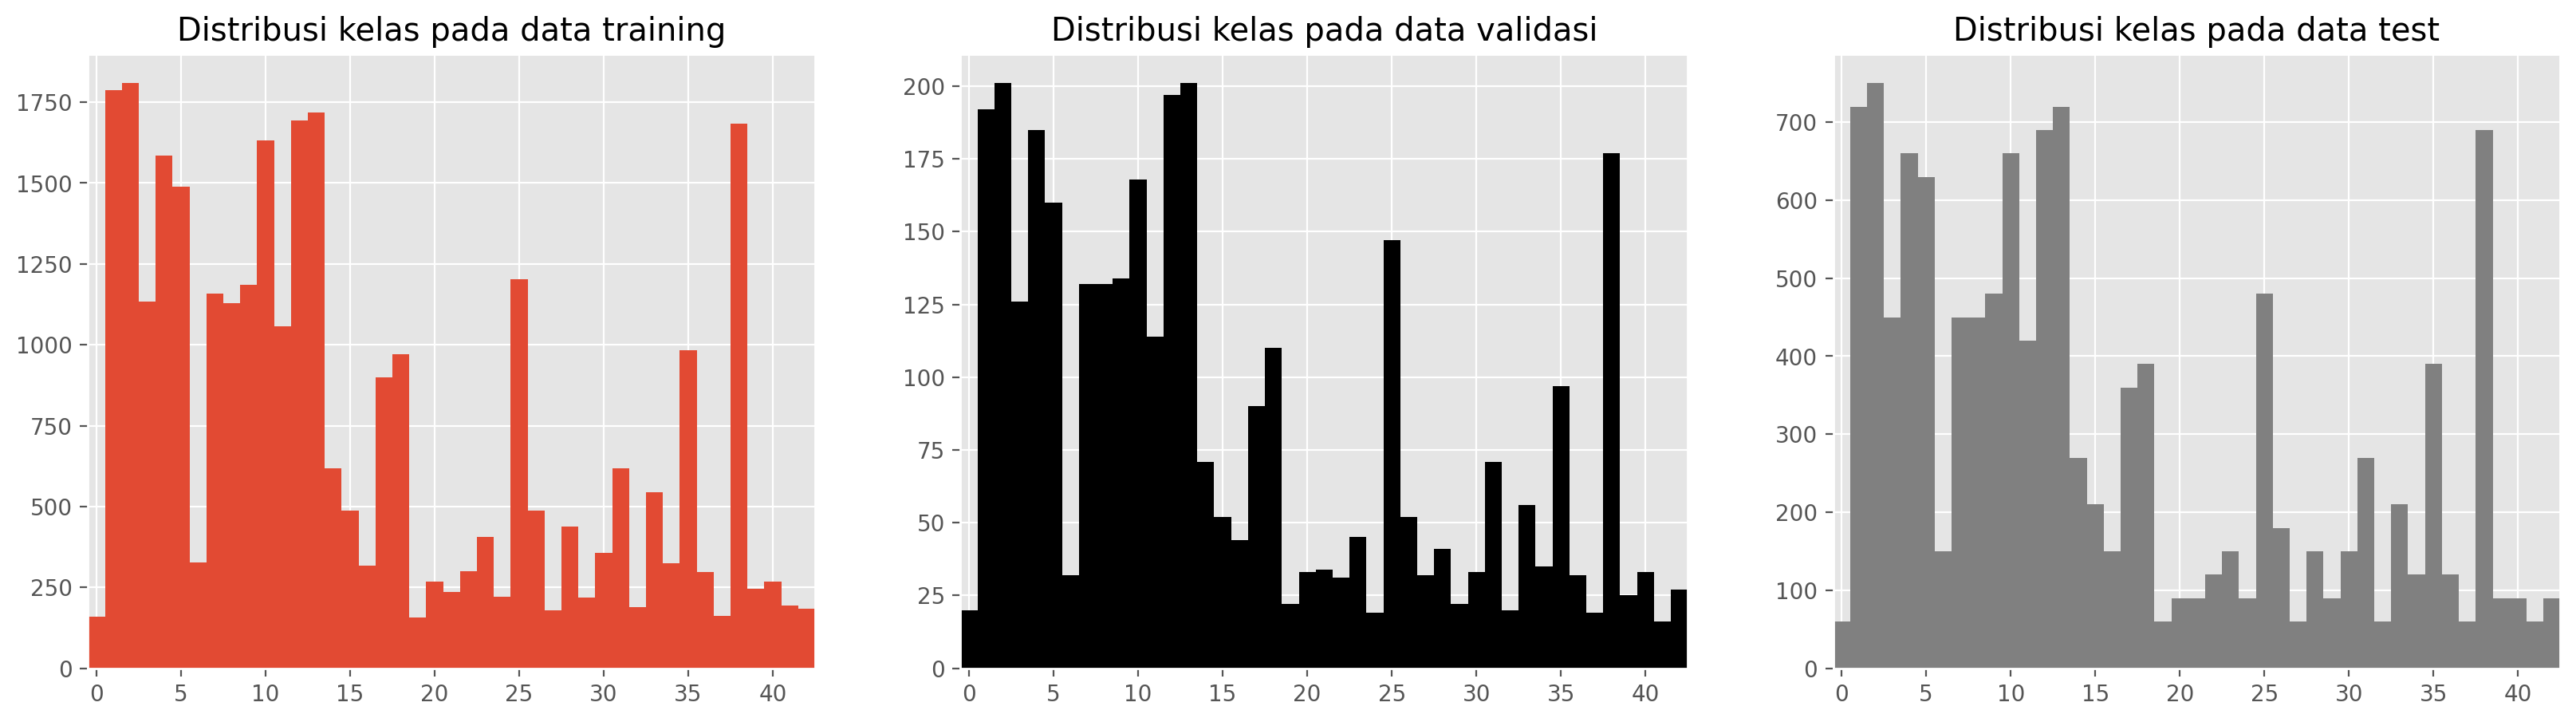

In [11]:
n_labels=np.unique(y_train).size
def hist_data(y_data,title=None,ax=None, **kwargs):
  if not ax:
    fig=plt.figure()
    ax=fig.add_subplot(111)
  ax.hist(y_data,np.arange(-0.5,n_labels+1.5),stacked=True,**kwargs)
  ax.set_xlim(-0.5,n_labels-0.5)
  if 'label' in kwargs:
    ax.legend()
  if title:
    ax.set_title(title)


fig,ax=plt.subplots(1,3,figsize=(20,5))
hist_data(y_train,title='Distribusi kelas pada data training',ax=ax[0])
hist_data(y_val,title='Distribusi kelas pada data validasi',ax=ax[1],color='black')
hist_data(y_test,title='Distribusi kelas pada data test',ax=ax[2],color='grey')


In [12]:
from tensorflow.keras.utils import to_categorical
y_train=to_categorical(y_train,43)
y_val=to_categorical(y_val,43)

In [13]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.96):
            print("\nAkurasi telah mencapai >96%. Stop training!")
            self.model.stop_training = True
callbacks = myCallback()

Memabangun lapisan model yaitu


*   2 lapisan konvolusi dengan fungsi aktivasiRelu
*   lapisan pengurangan dimensi menggunakan MaxPooling


*   lapisan Dropout untuk mengurangi overfitting
*   lapisan flatten untuk mengubah output ke dalam bentuk flat sebelum masuk ke lapisan Dense


*   2 lapisan Dense dengan fungsi aktivasi Relu dan Softmax










In [14]:
model=Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

Menampilkan ringkasan dari model dibuat dimulai berapa lapisan dan lain-lain

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                        

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Melakukan pelatihan model dengan jumlah epoch 50 dan pelatihan dalam satu waktu sebanyak 32 dan menampilkan loss,accuracy dan lain-lain

In [17]:
epochs = 25
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])

Epoch 1/25
979/979 [==============================] - 16s 8ms/step - loss: 1.8323 - accuracy: 0.5400 - val_loss: 0.4403 - val_accuracy: 0.8868
Epoch 2/25
979/979 [==============================] - 6s 6ms/step - loss: 0.7526 - accuracy: 0.7763 - val_loss: 0.3693 - val_accuracy: 0.9213
Epoch 3/25
979/979 [==============================] - 6s 6ms/step - loss: 0.5873 - accuracy: 0.8227 - val_loss: 0.2045 - val_accuracy: 0.9486
Epoch 4/25
979/979 [==============================] - 5s 5ms/step - loss: 0.4946 - accuracy: 0.8487 - val_loss: 0.1621 - val_accuracy: 0.9520
Epoch 5/25
979/979 [==============================] - 6s 6ms/step - loss: 0.4493 - accuracy: 0.8631 - val_loss: 0.1539 - val_accuracy: 0.9583
Epoch 6/25
979/979 [==============================] - 5s 5ms/step - loss: 0.4144 - accuracy: 0.8736 - val_loss: 0.2846 - val_accuracy: 0.9190
Epoch 7/25
979/979 [==============================] - 5s 5ms/step - loss: 0.3363 - accuracy: 0.8982 - val_loss: 0.1323 - val_accuracy: 0.9621
Epoch

Melakukan penyimpanan model setalah di lakukannya pelatihan model dalam bentuk file .h5

In [18]:
model.save("my_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
Melakukan visualisasi hasil setelah train dan didapat grafik hasil akurasi dan loss dari model setelah ditrain

<function matplotlib.pyplot.legend(*args, **kwargs)>

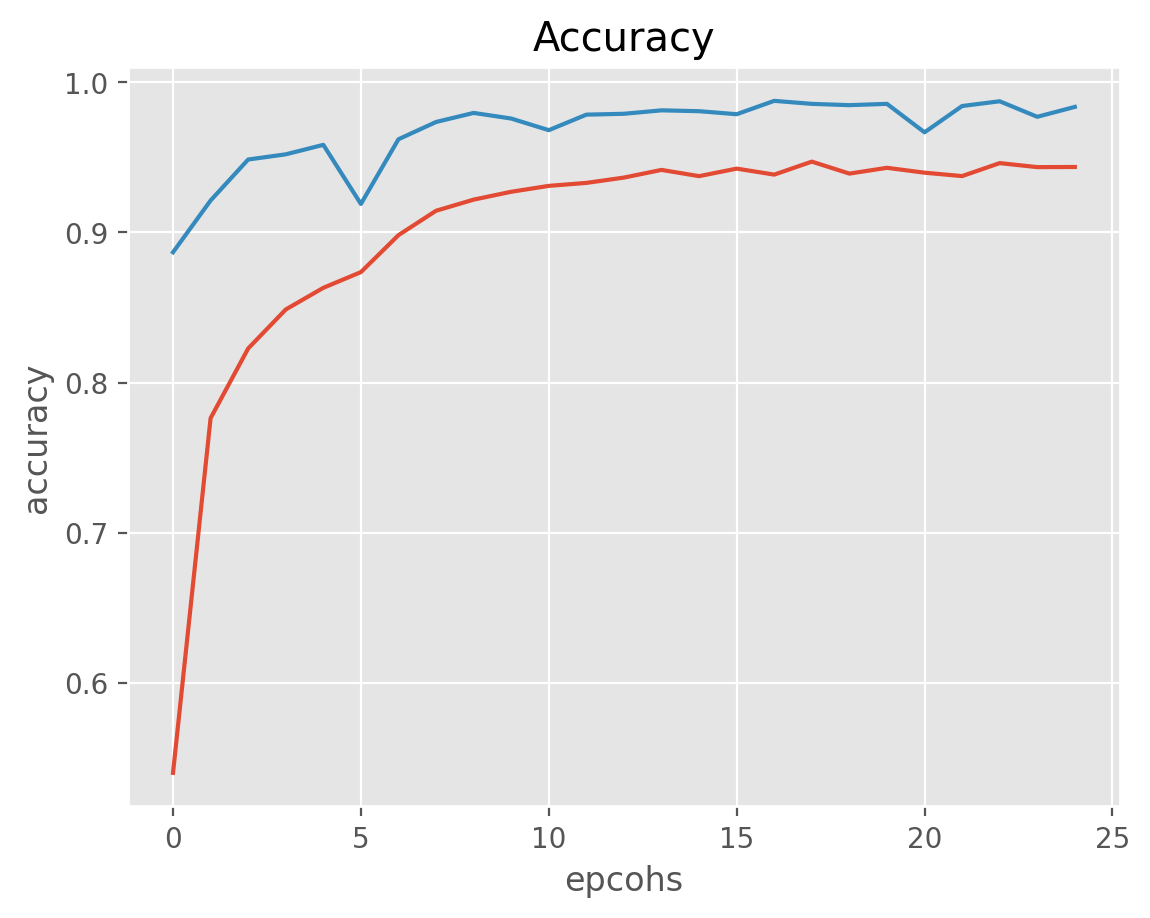

In [19]:
plt.figure(0)
plt.plot(history.history['accuracy'],label='training accuracy')
plt.plot(history.history['val_accuracy'],label='val loss')
plt.title('Accuracy')
plt.xlabel('epcohs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Melakukan evaluasi metrik dengan menggunakan accuracy score

In [20]:
from sklearn.metrics import accuracy_score

pred = np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, pred)
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

395/395 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.94      0.80      0.86        60
           1       0.97      0.96      0.97       720
           2       0.95      0.97      0.96       750
           3       0.88      0.96      0.92       450
           4       0.96      0.95      0.96       660
           5       0.92      0.88      0.90       630
           6       0.98      0.78      0.87       150
           7       0.94      0.95      0.95       450
           8       0.97      0.94      0.95       450
           9       0.94      0.99      0.97       480
          10       0.98      0.99      0.98       660
          11       0.91      0.92      0.92       420
          12       0.97      0.97      0.97       690
          13       0.99      0.98      0.99       720
          14       0.99      1.00      0.99       270
          15       0.91      1.00      0.95       210
          16       0.99   